# 중고차 가격 예측 모델 성능 비교 프로젝트 - 순차적 진행 절차
## 1. 문제 정의
- 목표: 중고차 데이터(Dubizzle_used_car_sales.csv)를 바탕으로, 차량 가격(price)을 예측하는 회귀 모델 성능 비교   
- 예측값 유형: 연속형 변수 → 회귀 모델 사용   
- 비교할 모델 (예시):   
    - 선형회귀 (Linear Regression)   
    - 릿지 회귀 (Ridge)   
    - 라쏘 회귀 (Lasso)   
    - 의사결정나무 (Decision Tree Regressor)   
    - 랜덤포레스트 (Random Forest Regressor)   
    - 그레이디언트 부스팅 (XGBoost 등)

## 2. 데이터 불러오기 & 탐색

In [1]:
import pandas as pd

df = pd.read_csv('Dubizzle_used_car_sales.csv')
df.head()
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9970 entries, 0 to 9969
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 9965 non-null   object 
 1   price_in_aed          9970 non-null   int64  
 2   kilometers            9970 non-null   int64  
 3   body_condition        9970 non-null   object 
 4   mechanical_condition  9970 non-null   object 
 5   seller_type           9970 non-null   object 
 6   body_type             9970 non-null   object 
 7   no_of_cylinders       9889 non-null   object 
 8   transmission_type     9970 non-null   object 
 9   regional_specs        9970 non-null   object 
 10  horsepower            9970 non-null   object 
 11  fuel_type             9970 non-null   object 
 12  steering_side         9970 non-null   object 
 13  year                  9000 non-null   float64
 14  color                 9970 non-null   object 
 15  emirate              

,price_in_aed,kilometers,year
count,9.970000e+03,9.970000e+03,9000.000000
mean,2.480496e+05,9.894896e+04,2015.626444
std,4.536549e+05,1.154300e+06,4.735991
min,6.000000e+03,0.000000e+00,1953.000000
25%,5.100000e+04,2.314350e+04,2014.000000
50%,1.040000e+05,7.600000e+04,2016.000000
75%,2.340000e+05,1.330828e+05,2019.000000
max,1.499900e+07,1.150000e+08,2021.000000


## 3. 데이터 전처리
- 필요 없는 열 제거 (예: ID, 이미지 링크 등)   
- 결측치 처리   
- 문자형 → 숫자형 변환 (Label Encoding or One-Hot Encoding)   
- 이상치 제거 or 로그 변환   
- 스케일링 적용 (특히 거리, 연식 등 수치형 변수에)

In [12]:
import numpy as np
import re

def clean_horsepower(hp):
    if isinstance(hp, str):
        hp = hp.strip()
        if hp.lower() == 'unknown':
            return np.nan
        # 예: '400 - 500 HP' → 평균값 450
        match = re.match(r"(\d+)\s*-\s*(\d+)", hp)
        if match:
            return (int(match.group(1)) + int(match.group(2))) / 2
        # 예: '500 HP' → 500
        match_single = re.match(r"(\d+)", hp)
        if match_single:
            return int(match_single.group(1))
        return np.nan
    return hp  

# 변환 적용
df['horsepower'] = df['horsepower'].apply(clean_horsepower)

# float로 변환 후 결측값 처리
df['horsepower'] = df['horsepower'].astype(float)
df['horsepower'] = df['horsepower'].fillna(df['horsepower'].mean())


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['kilometers', 'year', 'horsepower']] = scaler.fit_transform(df[['kilometers', 'year', 'horsepower']])


In [15]:
print(df.columns)

Index(['title', 'price_in_aed', 'kilometers', 'body_condition',
       'mechanical_condition', 'seller_type', 'body_type', 'no_of_cylinders',
       'transmission_type', 'regional_specs', 'horsepower', 'fuel_type',
       'steering_side', 'year', 'color', 'emirate', 'motors_trim', 'company',
       'model', 'date_posted'],
      dtype='object')


## 4. Feature Selection
타겟 변수: price

In [ ]:
#문자열 확인

print(df['body_condition'].unique())
print(df['mechanical_condition'].unique())


['Perfect inside and out' 'Normal wear & tear, a few issues'
 'A bit of wear & tear, all repaired' 'No accidents, very few faults']
['Perfect inside and out' 'Minor faults, all fixed'
 'Major faults fixed, small remain' 'Ongoing minor & major faults'
 'Major faults, all fixed']


In [29]:


# 설명문 컬럼 제거 + 날짜도 제외
X = df.drop(columns=['price_in_aed', 'title', 'date_posted'])

# 타겟 분리
y = df['price_in_aed']

In [30]:
categorical_cols = [
    'body_condition', 'mechanical_condition', 'seller_type', 'body_type',
    'no_of_cylinders', 'transmission_type', 'regional_specs', 'fuel_type',
    'steering_side', 'color', 'emirate', 'motors_trim', 'company', 'model'
]

# 캐스팅
for col in categorical_cols:
    X[col] = X[col].astype(str)


In [31]:
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)


## 5. 학습/테스트 데이터 분리

In [49]:
# 타겟 로그 변환
y_log = np.log1p(y)

# 학습/테스트 분리
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_encoded, y_log, test_size=0.2, random_state=42
)

# 모델 학습
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train_log)
    preds_log = model.predict(X_test)
    preds = np.expm1(preds_log)  # 로그 복원
    predictions[name] = preds


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_32928\2128212087.py:14: RuntimeWarning: overflow encountered in expm1
  preds = np.expm1(preds_log)  # 로그 복원


In [50]:
df_cleaned = df[df['price_in_aed'] < 1000000]


In [51]:
print(preds_log[:10])  # 로그 예측값 확인
print(np.max(preds_log))  # 최대값이 얼마나 큰지 확인


[10.342749  12.857138  11.9010515 10.549809  11.22615   13.155684
 10.293961  10.558287  13.99896   10.444729 ]
14.985258


In [52]:
# 예측값의 log가 너무 크면 잘라주자 (예: 최대 20까지)
preds_log = np.clip(preds_log, a_min=None, a_max=20)
preds = np.expm1(preds_log)
print("예측값 최소:", np.min(preds))
print("예측값 최대:", np.max(preds))


예측값 최소: 13231.28
예측값 최대: 3221178.2


13,000 AED면 저렴한 중고차
300만 AED면 슈퍼카 or 입력 오류 가능 차량

## 6. 모델 성능 평가
사용 지표:   
- MAE (Mean Absolute Error)   
- MSE (Mean Squared Error)   
- RMSE (Root Mean Squared Error)   
- R² (결정계수)

In [54]:
# 전 모델에 대해 예측값 정제
for name, model in models.items():
    model.fit(X_train, y_train_log)
    preds_log = model.predict(X_test)
    
    # log 예측값 클리핑
    preds_log = np.clip(preds_log, a_min=None, a_max=20)
    
    # 복원
    preds = np.expm1(preds_log)
    
    # 혹시 모를 inf, NaN 제거
    preds = np.nan_to_num(preds, nan=0.0, posinf=1e7, neginf=0.0)
    
    # 현실적인 범위로 한 번 더 클리핑 (0 ~ 2M AED)
    preds = np.clip(preds, a_min=0, a_max=2_000_000)
    
    predictions[name] = preds


In [55]:
for name, pred in predictions.items():
    print(f"{name} 성능")
    print(f"MAE : {mean_absolute_error(y_test, pred):,.2f}")
    print(f"MSE : {mean_squared_error(y_test, pred):,.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred)) :,.2f}")
    print(f"R²   : {r2_score(y_test, pred):.4f}")
    print()


LinearRegression 성능
MAE : 142,153.28
MSE : 240,203,324,930.14
RMSE: 490,105.42
R²   : 0.1556

Ridge 성능
MAE : 85,501.46
MSE : 148,090,707,658.60
RMSE: 384,825.55
R²   : 0.4794

Lasso 성능
MAE : 197,576.81
MSE : 301,572,000,914.82
RMSE: 549,155.72
R²   : -0.0602

DecisionTree 성능
MAE : 60,362.44
MSE : 108,483,334,393.28
RMSE: 329,368.08
R²   : 0.6186

RandomForest 성능
MAE : 53,107.30
MSE : 106,351,869,895.23
RMSE: 326,116.34
R²   : 0.6261

XGBoost 성능
MAE : 56,944.78
MSE : 126,996,122,621.99
RMSE: 356,365.15
R²   : 0.5535



In [57]:

# 시스템 환경에 따라 폰트를 자동으로 설정해주는 함수
def get_font_family():
    import platform
    system_name = platform.system()

    if system_name == "Darwin":
        return "AppleGothic"
    elif system_name == "Windows":
        return "Malgun Gothic"
    else:
        # Linux (Colab)
        !apt-get install fonts-nanum -qq > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont

        return "NanumBarunGothic"

# 한글 폰트 적용
plt.rc("font", family=get_font_family())
plt.rc("axes", unicode_minus=False)

# 레티나 디스플레이 설정 (선명하게)
%config InlineBackend.figure_format = 'retina'



C:\Users\LENOVO\AppData\Local\Temp\ipykernel_32928\3786250870.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=results, palette='Set3')


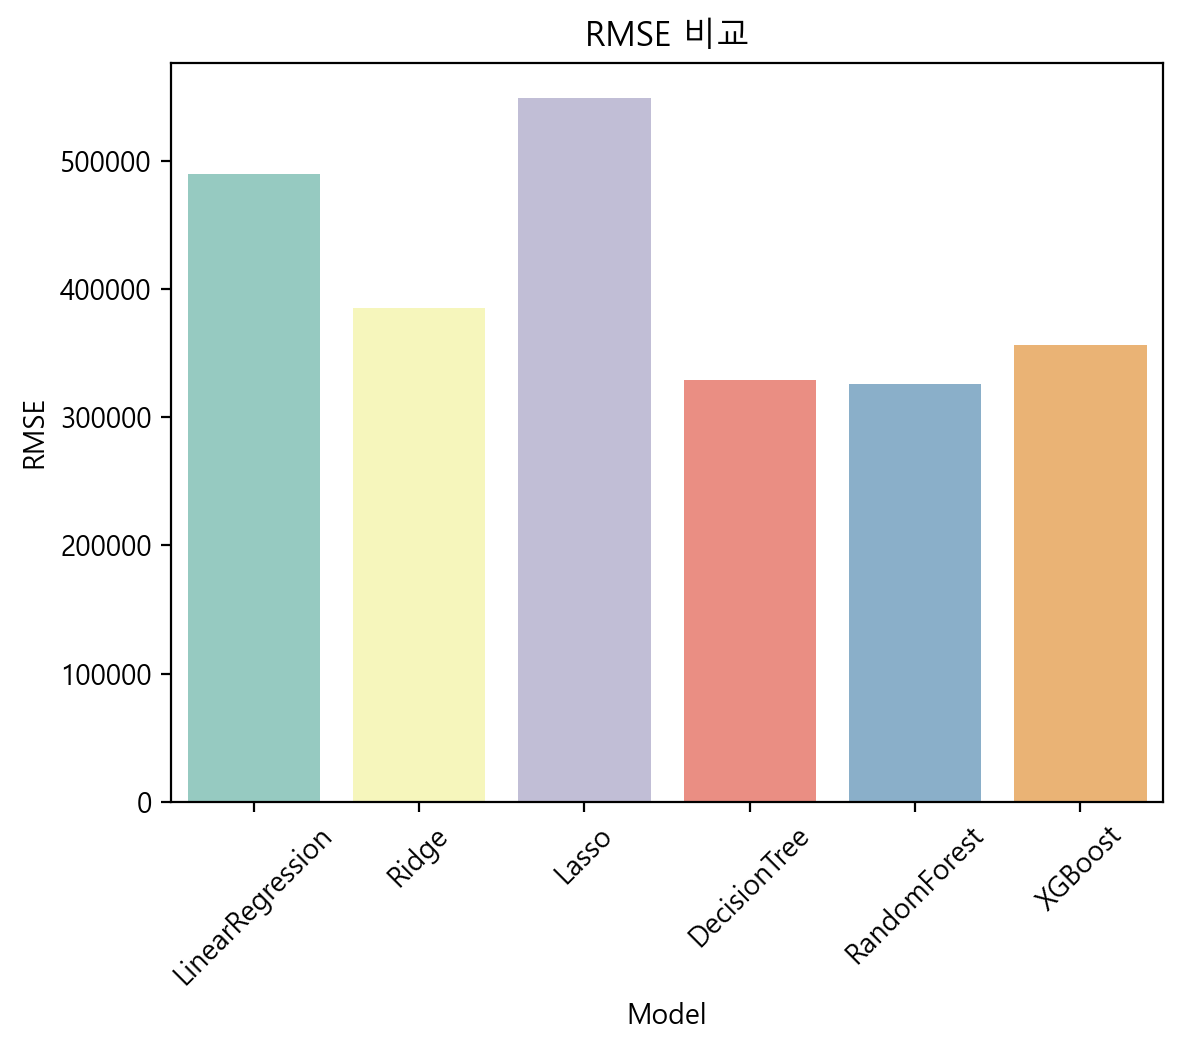

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns



results = pd.DataFrame({
    'Model': list(predictions.keys()),
    'RMSE': [np.sqrt(mean_squared_error(y_test, predictions[m])) for m in predictions],
    'R2': [r2_score(y_test, predictions[m]) for m in predictions]
})

sns.barplot(x='Model', y='RMSE', data=results, palette='Set3')
plt.title('RMSE 비교')
plt.xticks(rotation=45)
plt.show()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_32928\1508208116.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2', data=results, palette='Set3')


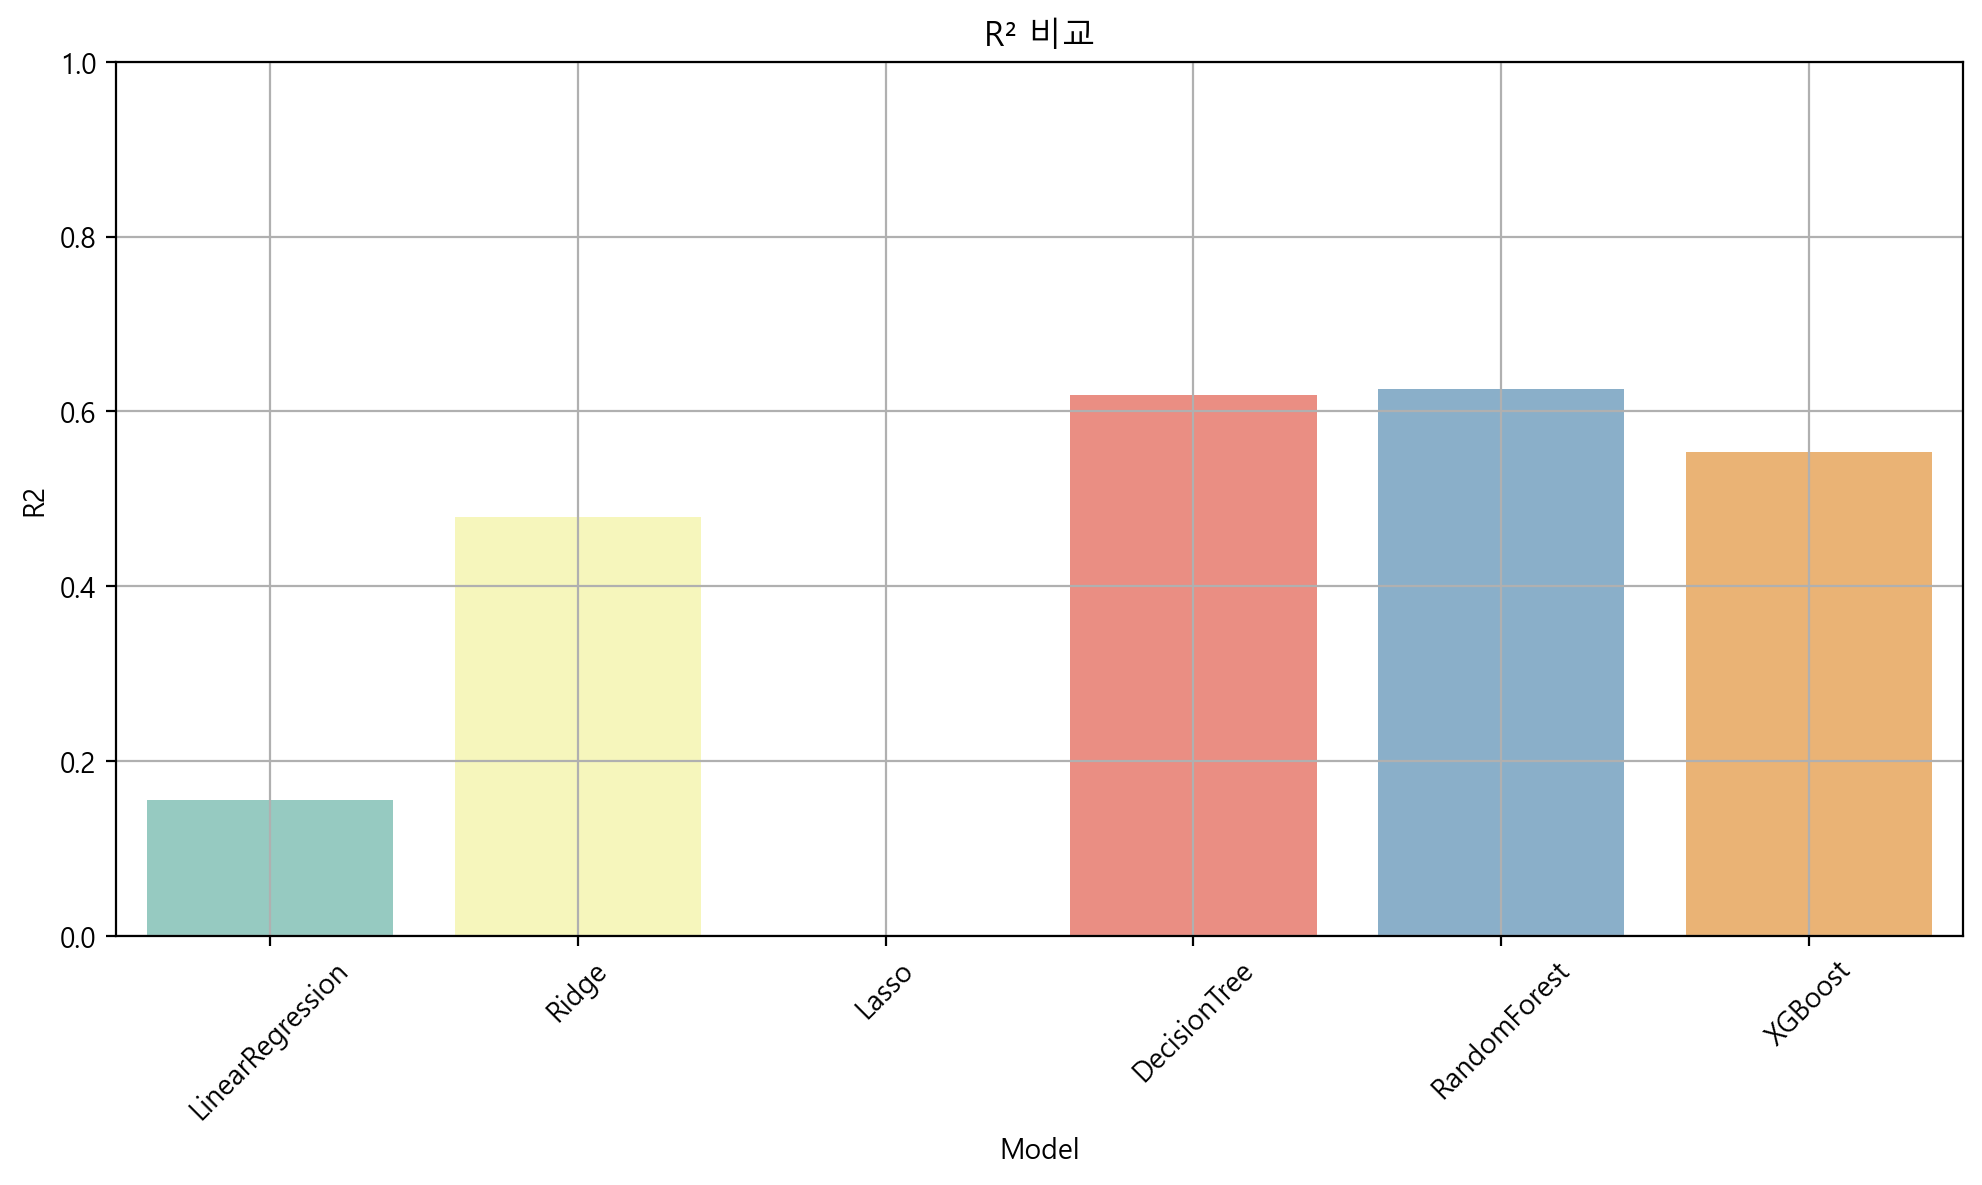

In [61]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='R2', data=results, palette='Set3')
plt.title('R² 비교')
plt.ylim(0, 1)  # R²는 일반적으로 0~1 사이 (음수면 안 좋은 모델)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## 7. 그래프 해석 포인트
- 1에 가까울수록 좋음   
- 0.7 이상이면 꽤 설명 잘한 거고,   
    0.3 이하면 설명력 부족 (모델 개선 필요)   
- 음수면 → 예측이 평균값보다 못한 경우 (모델 완전 실패)

### 결론
RandomForest Regressor가 현재 데이터에서는   
가장 안정적이고 정확한 중고차 가격 예측 모델로 보인다.

## 8. 결론 및 인사이트 도출

### 1. 가장 성능이 우수한 모델
- Random Forest Regressor는 R²(설명력) 0.63, RMSE(평균 오차 약 33만 AED)로,
전체 모델 중 가장 안정적인 예측 성능을 보였다.   
- Decision Tree Regressor도 유사한 수준의 성능을 보이며, 단순성과 속도 면에서 유리한 대안이 될 수 있다.   
- 반면 Lasso 및 Linear Regression 모델은 설명력과 예측 정확도 모두 낮아, 본 데이터에서는 적합하지 않았다.

### 2. 과적합 여부
- Random Forest와 Decision Tree는 트리 기반 모델 특성상 과적합 위험이 존재하지만,   
테스트 데이터에서도 우수한 성능을 유지한 점으로 보아 현재는 과적합이 심하지 않은 것으로 판단된다.   
단, 예측값 분포 상 일부 이상치가 존재하므로 추후 K-Fold Cross Validation 등 추가 검증이 필요하다.

### 3. 모델 해석 가능성
- 선형 회귀 계열 모델(Ridge, Lasso)은 해석 가능성은 높지만 예측 성능이 낮았다.   
- 반면, 트리 기반 모델(Random Forest, XGBoost)은 해석력은 낮지만 성능이 높았다.   
- 중고차 가격 예측처럼 설명보다 예측 정확도가 중요한 문제에서는 Random Forest가 더    합하다.

### 4.  향후 개선 방향
1. 하이퍼파라미터 튜닝   
- GridSearchCV, RandomizedSearchCV를 통해 최적의 파라미터 조합 탐색

2. 이상치 정교화   
- price_in_aed 및 주행거리(km), 마력(horsepower) 등 주요 피처에 대해 로그 변환, IQR 기반 이상치 제거

3. 피처 엔지니어링   
- 연식(year)과 모델명(model), 회사(company) 조합 등 의미 있는 새로운 파생변수 생성

4. 딥러닝 도입 (선택사항)   
- DNN(Deep Neural Network) 또는 TabNet 등 구조 적용 가능   
- 다만 샘플 수가 적다면 과적합 위험 존재

## 9. 결론 도출
**트리 기반 모델(Random Forest, Decision Tree)** 은   
중고차 가격처럼 다차원적 요인이 복합적으로 작용하는 문제에 효과적이며,   
향후 이상치 처리 + 튜닝 + 교차검증 등을 통해 예측력을 더욱 높일 수 있다.